In [0]:
#change this to be the Class with first letter upper case do Tree first, then Apple
CNAME="T-shirt"

In [39]:
pip install tensorboardX

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/ML_Project')

In [0]:
from IPython import display
from utils import Logger
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable
import cv2
from torchvision import transforms, datasets
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
DATA_FOLDER = './torch_data/DCGAN/MNIST'

## Load Data

In [0]:
#You might have to run this cell twice. it sometimes fails
dataroot = "/content/drive/My Drive/ML_Project/local imgs/"+CNAME+"/"
data = dset.ImageFolder(root=dataroot,transform=transforms.Compose([
                                                      transforms.Grayscale(num_output_channels=1),
                                                      transforms.Resize(64),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize((0.5,), (0.5,))
                                                      ]))

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

## Networks

In [0]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        #print(type(x))
        #print(x.shape)
        x = self.conv1(x)
        #print(type(x))
        #print(x.shape)
        x = self.conv2(x)
        #print(type(x))
        #print(x.shape)
        x = self.conv3(x)
        #print(type(x))
        #print(x.shape)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        #print(type(x))
        #print(x.shape)
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [0]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [0]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

## Optimization

In [0]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 10

## Training

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

In [37]:
logger = Logger(model_name='DCGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

KeyboardInterrupt: ignored

Post


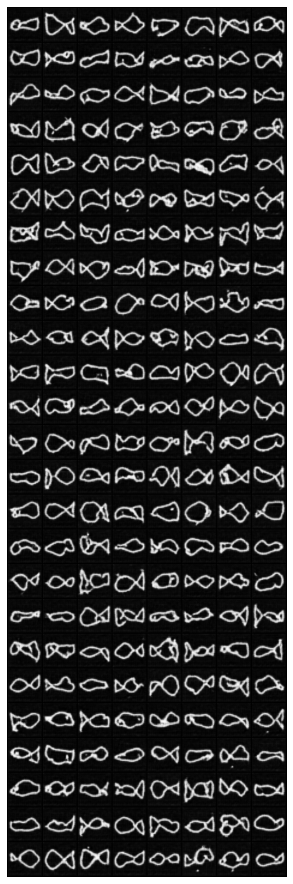

In [52]:
#Sanity check to see if images are being produced correctly
generator= GenerativeNet()
od=torch.load('/content/drive/My Drive/ML_Project/GAN Data/Fish/data/models/DCGAN/MNIST/G_epoch_9')
generator.load_state_dict(od)
num_test_samples = 200
test_noise = noise(num_test_samples)
test_images = generator(test_noise).data.cpu()
logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);

torch.Size([1000, 1, 64, 64])
(1000, 64, 64)


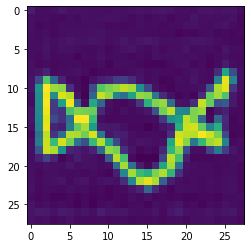

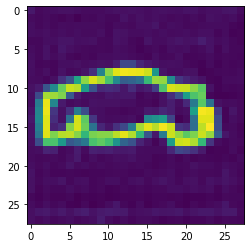

(1000, 784)


In [54]:
#image to numpy conversion
num_test_samples = 1000
test_noise = noise(num_test_samples)
test_images = generator(test_noise).data.cpu()
print(test_images.shape)
nptd= test_images.numpy()
nptd=nptd.reshape(num_test_samples,64,64)
print(nptd.shape)

new_nptd=[]
for im in nptd:
  temp= cv2.resize(im, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
  new_nptd.append(temp)
new_nptd=np.array(new_nptd)
plt.imshow(new_nptd[34])
plt.show()
plt.imshow(new_nptd[543])
plt.show()
new_nptd.resize(num_test_samples,784)
print(new_nptd.shape)

In [0]:
#add in right directory
import shutil

sourceDir = "./data"
destDir =  "/content/drive/My Drive/ML_Project/GAN Data/"+CNAME
npfile= destDir+"/"+CNAME.lower()+"_gan.npy"
os.mkdir(destDir)
 
shutil.move(sourceDir, destDir)
np.save(npfile,new_nptd)

In [55]:
classes=["Tree","Apple","Car","Fish","Bowtie","Face","T-shirt","Ice cream","Flamingo","Sheep"]
for cl in classes:
    print(cl)
    pth='/content/drive/My Drive/ML_Project/GAN Data/'+cl+'/data/models/DCGAN/MNIST/G_epoch_9'
    generator= GenerativeNet()
    od=torch.load(pth)
    generator.load_state_dict(od)

    num_test_samples = 1000
    test_noise = noise(num_test_samples)
    test_images = generator(test_noise).data.cpu()
    print(test_images.shape)
    nptd= test_images.numpy()
    nptd=nptd.reshape(num_test_samples,64,64)
    print(nptd.shape)

    new_nptd=[]
    for im in nptd:
      temp= cv2.resize(im, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
      new_nptd.append(temp)
    new_nptd=np.array(new_nptd)

    #plt.imshow(new_nptd[34])
    #plt.show()
    #plt.imshow(new_nptd[543])
    #plt.show()

    new_nptd.resize(num_test_samples,784)
    print(new_nptd.shape)
    destDir =  "/content/drive/My Drive/ML_Project/GAN Data/"+cl
    npfile= destDir+"/"+cl.lower()+"_gan.npy"
    np.save(npfile,new_nptd)
    print("saved")
    print()

Tree
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Apple
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Car
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Fish
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Bowtie
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Face
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

T-shirt
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Ice cream
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Flamingo
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

Sheep
torch.Size([1000, 1, 64, 64])
(1000, 64, 64)
(1000, 784)
saved

